In [1]:
import numpy as np
import scipy
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import sys
base_dir = '/home2/ebrahim/neural_seq_decoder/' 
sys.path.append(f"{base_dir}/scripts/")
from preprocessing import zscore_by_blocks, get_trial_numbers
from load_data import store_data_to_pandas, select_block_ids
from scipy.io import loadmat
from himalaya.ridge import Ridge, RidgeCV
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import himalaya
import torch
backend = himalaya.backend.set_backend("torch_cuda")
device = 0
torch.cuda.set_device(device)
from sklearn.base import BaseEstimator
from copy import deepcopy

In [2]:
load_data_from_pickle = True

In [3]:
if load_data_from_pickle:
    
    all_sessions = pd.read_pickle(f"/data/LLMs/willet/all_sessions_pd.pkl")  
      
else:

    session_pd_store = []
    counter = 0

    for file in os.listdir(f"{base_dir}sentences/"):
        
        print("loading session data")
        session_dict = scipy.io.loadmat(f'{base_dir}sentences/{file}')
        session_name = file.split('_')[0].replace('t12.2022.', '')

        session_pd = store_data_to_pandas(session_dict, session_name=session_name)
        
        session_pd_store.append(session_pd)
        
    all_sessions = pd.concat(session_pd_store)
    all_sessions.to_pickle('/data/LLMs/willet/all_sessions_pd.pkl')

In [4]:
all_sessions['block+sess'] = all_sessions['blockNum'].astype(str) + '_' + all_sessions['session']

/tmp/ipykernel_2721481/2843311109.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_sessions['block+sess'] = all_sessions['blockNum'].astype(str) + '_' + all_sessions['session']


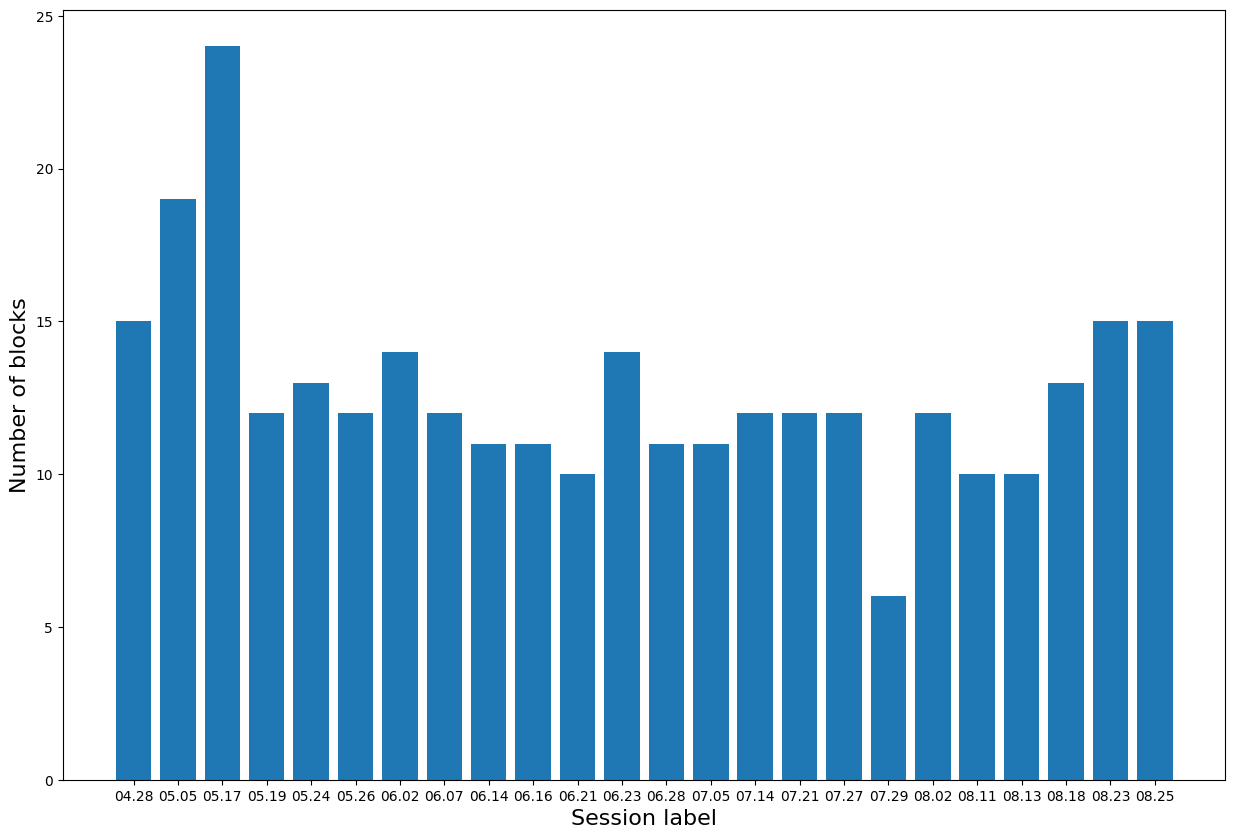

In [5]:
block_sess = deepcopy(np.unique(all_sessions['block+sess']))
session_names, block_counts = np.unique([s.split('_')[1] for s in block_sess], return_counts=True)
plt.figure(figsize=(15,10))
plt.bar(session_names, block_counts)
plt.ylabel("Number of blocks", fontsize=16)
plt.xlabel("Session label", fontsize=16)
plt.savefig("/home2/ebrahim/neural_seq_decoder/figures/num_blocks_per_session")
plt.show()

In [6]:
block_sess_dict = {}
block_sess = deepcopy(np.unique(all_sessions['block+sess']))
for sb in block_sess:
    sess = sb.split('_')[1]
    b = sb.split('_')[0]
    if sess not in block_sess_dict:
        block_sess_dict[sess] = []
    if b not in block_sess_dict[sess]:
        block_sess_dict[sess].append(b)

In [7]:
tx = True
if tx:
    print("using tx")
    select_column = 'tx-'
else:
    print("using spike pow")
    select_column = 'pow-'
    
all_sessions_neural_data = all_sessions.filter(regex=select_column)
ba_44_neural = np.array(all_sessions_neural_data.filter(regex='44-')).astype("float32")
ba_6v_neural = np.array(all_sessions_neural_data.filter(regex='6v-')).astype("float32")

using tx


In [8]:
c = 0
for bs in block_sess:
    block_sess_idxs = np.argwhere(all_sessions['block+sess']==bs) 
    print(block_sess_idxs.shape[0])   
    ba_44_neural[block_sess_idxs] = scipy.ndimage.gaussian_filter1d(ba_44_neural[block_sess_idxs], axis=0, sigma=2)
    ba_6v_neural[block_sess_idxs] = scipy.ndimage.gaussian_filter1d(ba_6v_neural[block_sess_idxs], axis=0, sigma=2)
    c+=1
    print(f"Block number {c} out of {block_sess.shape[0]}")

20124
Block number 1 out of 306
19353
Block number 2 out of 306
13095
Block number 3 out of 306
10611
Block number 4 out of 306
19000
Block number 5 out of 306
20731
Block number 6 out of 306
18218
Block number 7 out of 306
18112
Block number 8 out of 306
18273
Block number 9 out of 306
19617
Block number 10 out of 306
17430
Block number 11 out of 306
17383
Block number 12 out of 306
25015
Block number 13 out of 306
23070
Block number 14 out of 306
22136
Block number 15 out of 306
21872
Block number 16 out of 306
22529
Block number 17 out of 306
23810
Block number 18 out of 306
24040
Block number 19 out of 306
22827
Block number 20 out of 306
19859
Block number 21 out of 306
19686
Block number 22 out of 306
12891
Block number 23 out of 306
10883
Block number 24 out of 306
20447
Block number 25 out of 306
21703
Block number 26 out of 306
18504
Block number 27 out of 306
17721
Block number 28 out of 306
20189
Block number 29 out of 306
21474
Block number 30 out of 306
23436
Block number 

In [9]:
np.save('/data/LLMs/willet/smooth_ba44_tx', ba_44_neural)
np.save('/data/LLMs/willet/smooth_ba6v_tx', ba_6v_neural)

In [15]:
# Ensure the column is of type str
all_sessions['block+sess'] = all_sessions['block+sess'].astype(str)

# Convert to numpy array
np.save('/data/LLMs/willet/block_sess', np.array(all_sessions['block+sess'], dtype=str))

In [47]:
X = ba_6v_neural[:, ::2]
y = ba_6v_neural[:, 1::2]

In [61]:
def create_block_sess_dict(block_sess):
    '''
    :param ndarray block_sess: unique block_session-names 
    '''
    
    block_sess_dict = {}
    for sb in block_sess:
        sess = sb.split('_')[1]
        b = sb.split('_')[0]
        if sess not in block_sess_dict:
            block_sess_dict[sess] = []
        if b not in block_sess_dict[sess]:
            block_sess_dict[sess].append(b)
            
    return block_sess_dict

In [62]:
class blockCV(BaseEstimator):
    
    def __init__(self, block_sess, block_sess_dict, n_splits):
        
        '''
        :param ndarray: numpy array where each element is a string of format BN_SESS, where BN is the block number
        and SESS is the session name
        :param dict block_sess_dict: each key is a session name, and the values are lists containing the block numbers for that seesssion
        :param int n_splits: the number of k-fold splits 
        '''
        
        self.block_sess = block_sess
        self.block_sess_dict = block_sess_dict
        self.n_splits = n_splits
            
    def split(self, X, y=None, groups=None):
        
        '''
        This function yields train and test indices such that 1/n_splits blocks from each session are placed into test
        and the remaining blocks are placed into the training set.
        '''

        # Precompute block-to-index mappings for fast lookup
        block_sess_dict_rev = {}
        for idx, block_sess in enumerate(self.block_sess):
            block, sess_name = block_sess.split('_', 1)
            if (block, sess_name) not in block_sess_dict_rev:
                block_sess_dict_rev[(block, sess_name)] = []
            block_sess_dict_rev[(block, sess_name)].append(idx)

        for split_idx in range(self.n_splits):
            
            train_idx, test_idx = [], []

            for sess_name, blocks in self.block_sess_dict.items():
                blocks = np.array(blocks)
                
                # Split the blocks into n_splits parts
                splits = np.array_split(blocks, self.n_splits)
                
                # Test blocks for this split
                test_blocks = splits[split_idx]
                # Training blocks are all other blocks
                train_blocks = np.concatenate(splits[:split_idx] + splits[split_idx + 1:])
            
                # Find the indices in the original array corresponding to these blocks
                test_block_indices = [block_sess_dict_rev[(block, sess_name)] for block in test_blocks]
                train_block_indices = [block_sess_dict_rev[(block, sess_name)] for block in train_blocks]

                test_idx.extend(np.concatenate(test_block_indices))
                train_idx.extend(np.concatenate(train_block_indices))
                
            yield np.array(train_idx), np.array(test_idx)
        
       
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

In [ ]:
all_sessions.head()

In [64]:
# Define the parameter grid for alpha (regularization strength)
alphas = np.exp2(np.arange(-5, 40, 1))
alphas = np.hstack((0,alphas))
param_grid = {'alpha': alphas}
n_splits = 6

# Create the outer cross-validation based on sentence IDs
outer_cv = blockCV(all_sessions['block+sess'], block_sess_dict, n_splits)

# Prepare to store results
cv_results = []

fold_number = 0
r2_folds = []

y_pred_all = []
y_pred_intercept_all = []
y_test_all = []
best_alpha = []

for train_idx, test_idx in outer_cv.split(None):
    
    # Initialize the Ridge regression model
    ridge = Ridge()

    print(f"Fold number: {fold_number}")
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    block_sess_train = np.array(all_sessions['block+sess'])[train_idx].squeeze()
    block_sess_train_dict = create_block_sess_dict(np.unique(block_sess_train))
    inner_cv = CustomCV(block_sess_train, block_sess_train_dict, n_splits=n_splits)
    
    # Set up the grid search with cross-validation
    grid_search = GridSearchCV(ridge, param_grid, cv=inner_cv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    # Evaluate the best model on the outer test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_null = np.repeat(np.expand_dims(np.mean(X_train, axis=0),axis=0), X_test.shape[0], axis=0)
    
    y_pred_all.append(y_pred)
    y_pred_intercept_all.append(y_pred_null)
    y_test_all.append(y_test)
    
    best_alpha.append(grid_search.best_params_['alpha'])
    
    print(f"Best alpha for this fold: {grid_search.best_params_['alpha']}")
    
    fold_number += 1

y_pred_all_np = np.vstack(y_pred_all)
y_test_all_np = np.vstack(y_test_all)
y_intercept_all_np = np.vstack(y_pred_intercept_all)

r2_oos = 1 - mean_squared_error(y_test_all_np, y_pred_all_np, multioutput='raw_values')/mean_squared_error(y_test_all_np, y_intercept_all_np, multioutput='raw_values')

r, p = pearsonr(y_test_all_np, y_pred_all_np, axis=0)

r2 = r2_score(y_test_all_np, y_pred_all_np, multioutput='raw_values')

In [ ]:

# Prepare to store results
cv_results = []

fold_number = 0
r2_folds = []

y_pred_all = []
y_pred_intercept_all = []
y_test_all = []
best_alpha = []

for train_sentence_index, test_sentence_index in outer_cv.split(unique_sentence_ids):
    
    # Initialize the Ridge regression model
    ridge = Ridge()

    print(f"Fold number: {fold_number}")
    
    train_sentences = unique_sentence_ids[train_sentence_index]
    test_sentences = unique_sentence_ids[test_sentence_index]
    
    # Get train/test indices
    train_idx = np.isin(sentence_ids, train_sentences)
    test_idx = np.isin(sentence_ids, test_sentences)
   
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    sentence_ids_train = sentence_ids[train_idx]
    
    inner_cv = CustomCV(sentence_ids_train, n_splits=5)

    # Set up the grid search with cross-validation
    grid_search = GridSearchCV(ridge, param_grid, cv=inner_cv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    # Evaluate the best model on the outer test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_null = np.repeat(np.expand_dims(np.mean(X_train, axis=0),axis=0), X_test.shape[0], axis=0)
    
    y_pred_all.append(y_pred)
    y_pred_intercept_all.append(y_pred_null)
    y_test_all.append(y_test)
    
    best_alpha.append(grid_search.best_params_['alpha'])
    
    print(f"Best alpha for this fold: {grid_search.best_params_['alpha']}")
    
    fold_number += 1

y_pred_all_np = np.vstack(y_pred_all)
y_test_all_np = np.vstack(y_test_all)
y_intercept_all_np = np.vstack(y_pred_intercept_all)

r2_oos = 1 - mean_squared_error(y_test_all_np, y_pred_all_np, multioutput='raw_values')/mean_squared_error(y_test_all_np, y_intercept_all_np, multioutput='raw_values')

r, p = pearsonr(y_test_all_np, y_pred_all_np, axis=0)

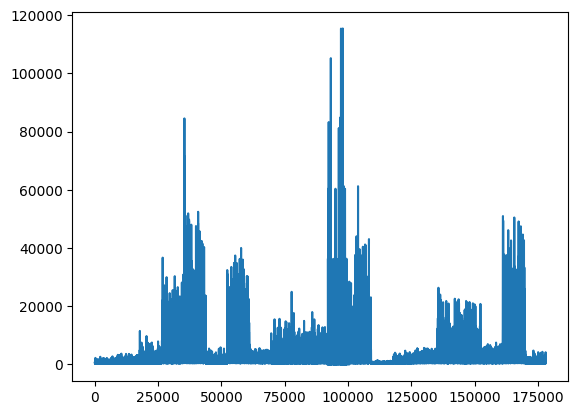

In [143]:
plt.plot(X[:, 10])

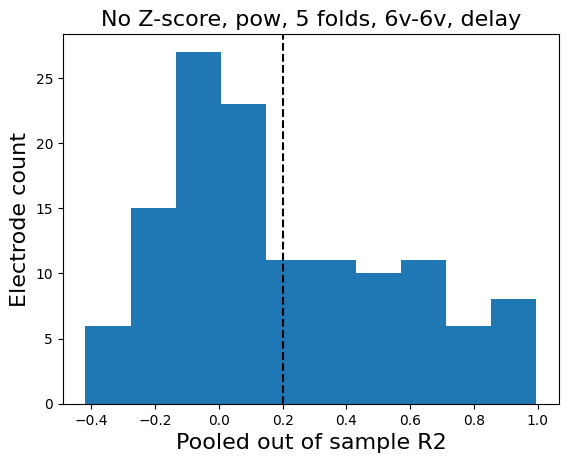

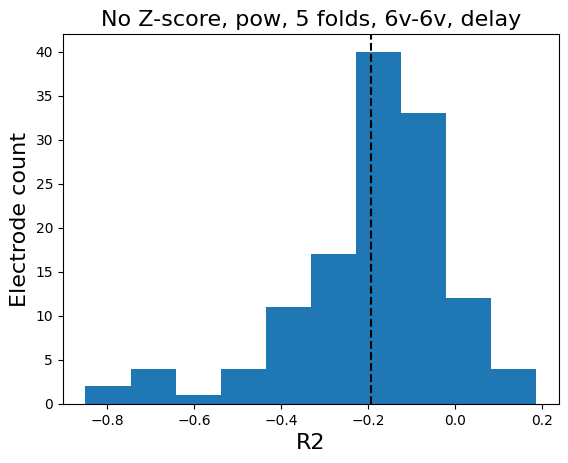

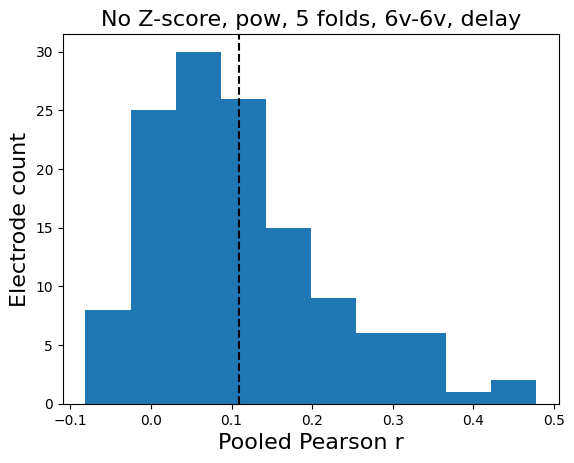

In [146]:
plt.ylabel('Electrode count', fontsize=16)
plt.xlabel("Pooled out of sample R2", fontsize=16)
plt.title(f"{zscore_str}, {select_column[:-1]}, 5 folds, 6v-6v, {delay_str}", fontsize=16)
plt.hist(r2_oos)
plt.axvline(np.mean(r2_oos), linestyle='--', color='black')
plt.show()

plt.ylabel('Electrode count', fontsize=16)
plt.xlabel("R2", fontsize=16)
plt.title(f"{zscore_str}, {select_column[:-1]}, 5 folds, 6v-6v, {delay_str}", fontsize=16)
plt.hist(r2)
plt.axvline(np.mean(r2), linestyle='--', color='black')
plt.show()


plt.ylabel('Electrode count', fontsize=16)
plt.xlabel("Pooled Pearson r", fontsize=16)
plt.title(f"{zscore_str}, {select_column[:-1]}, 5 folds, 6v-6v, {delay_str}", fontsize=16)
plt.hist(r)
plt.axvline(np.mean(r), linestyle='--', color='black')
plt.show()